# Dense networks on CIFAR10

In this lab you will see how well neural networks with fully connected layers perform on a dataset with more complex images. For example, CIFAR10 images have RGB values and thus each pixel corresponds to three values.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data

import time

In [2]:
# Choose which device to use
use_cuda = True

if use_cuda and torch.cuda.is_available():
  device = torch.device('cuda')
else:
  device = torch.device('cpu')

device

device(type='cuda')

### Load the dataset

In [3]:
import torchvision
import torchvision.transforms as transforms

# Apply transformations to the data points before passing them to the network
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))])  # The data is normalized by subtracting the mean and dividing by the std (corresponding to each channel)

trainset = torchvision.datasets.CIFAR10(root='./data_cifar', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data_cifar', train=False,
                                       download=True, transform=transform)

batch_size = 128
w, h, c = 32, 32, 3  # Width, Height, Nr. of channels for the input images (RGB)
k = 10  # Number of output classes

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batch_size,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=batch_size,
                                         shuffle=True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data_cifar/cifar-10-python.tar.gz to ./data_cifar
Files already downloaded and verified


### Show image examples

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 32, 32])
torch.Size([128, 3, 32, 32])


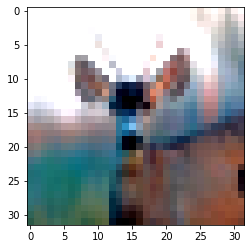

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


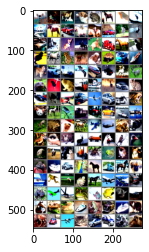

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images[0].shape)
print(images.shape)

# show images
imshow(images[0])
imshow(torchvision.utils.make_grid(images))

### Exercise - Defining an architecture

In this lab we will use fully connected neural networks. Create a dense neural network class that has a variable number of layers and layer sizes. The hidden layers have ReLu activation. The output layer should not apply any activation function.

In [35]:
class MLP(nn.Module):

  def __init__(self,
               input_size,  # Size of the input. Here we will first flatten the image to a single vector with the 3 * 32 * 32 values in the image 
               layer_sizes,  # A tuple containing the sizes of the hidden layers of the neural network. So to create a NN with two hidden layers with 32 neurons in each layer you'd set layer_sizes=(32,32)
               output_size):  # The size of the network output. CIFAR10 has 10 output classes
    super(MLP, self).__init__()
    
    self.layers = nn.ModuleList([nn.Linear(input_size,layer_sizes[0])])
    self.layers.extend([nn.Linear(layer_sizes[i],layer_sizes[i+1]) for i in range(len(layer_sizes)-1)])
    self.layers.append(nn.Linear(layer_sizes[-1],output_size))

  def forward(self, x):
    for layer in self.layers[:-1]:
      x = F.relu(layer(x))
    return self.layers[-1](x)


In [36]:
model = MLP(w * h * c, (128, 128), k).to(device)  # Create a new dense neural network with two hidden layers of size 128

print(model)

MLP(
  (layers): ModuleList(
    (0): Linear(in_features=3072, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=10, bias=True)
  )
)


### Train the network

Finish the code below so the network is trained on the images. The network should be able to reach an accuracy of about 50%. This is much better than taking random guesses, so the network did learn something. However, it is not a great classifier either. Dense neural networks are usually not the way to go for image classification. Instead, Convolutional Neural Networks are often used. These will be covered in the next lecture.

In [40]:
start=time.time()

criterion = nn.CrossEntropyLoss()

lr = 0.01
momentum = 0.9
num_epochs = 25

optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

for epoch in range(1, num_epochs + 1):
  # Iterate through the entire train set
  for i, (x_batch, y_batch) in enumerate(trainloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used
    
    # Perform an optimization step on the network weights using the gradient of the loss function
    optimizer.zero_grad()
    inputs = x_batch.view(-1, w*h*c)

    y_pred = model(inputs)

    loss = criterion(y_pred, y_batch)

    loss.backward()
    optimizer.step()

    # Compute relevant metrics
        
    y_pred_max = torch.argmax(y_pred, dim=1)  # Get the labels with highest output probability

    correct = torch.sum(torch.eq(y_pred_max, y_batch)).item()  # Count how many are equal to the true labels

    elapsed = time.time() - start  # Keep track of how much time has elapsed

    # Show progress every 20 batches 
    if not i % 20:
      print(f'epoch: {epoch}, time: {elapsed:.3f}s, loss: {loss.item():.3f}, train accuracy: {correct / batch_size:.3f}')
    
  # Evaluate the model on the test set
  correct_total = 0
  for i, (x_batch, y_batch) in enumerate(testloader):
    x_batch, y_batch = x_batch.to(device), y_batch.to(device)  # Move the data to the device that is used

    y_pred = model(x_batch.view(-1, w * h * c))
    y_pred_max = torch.argmax(y_pred, dim=1)

    correct_total += torch.sum(torch.eq(y_pred_max, y_batch)).item()

  print(f'Test accuracy: {correct_total / len(testset.data):.3f}')



epoch: 1, time: 0.032s, loss: 0.678, train accuracy: 0.758
epoch: 1, time: 0.575s, loss: 0.771, train accuracy: 0.742
epoch: 1, time: 1.112s, loss: 0.804, train accuracy: 0.719
epoch: 1, time: 1.641s, loss: 0.964, train accuracy: 0.656
epoch: 1, time: 2.169s, loss: 0.825, train accuracy: 0.727
epoch: 1, time: 2.711s, loss: 0.716, train accuracy: 0.758
epoch: 1, time: 3.247s, loss: 0.906, train accuracy: 0.695
epoch: 1, time: 3.777s, loss: 0.675, train accuracy: 0.750
epoch: 1, time: 4.308s, loss: 0.760, train accuracy: 0.672
epoch: 1, time: 4.831s, loss: 0.848, train accuracy: 0.688
epoch: 1, time: 5.361s, loss: 0.830, train accuracy: 0.695
epoch: 1, time: 5.913s, loss: 0.853, train accuracy: 0.703
epoch: 1, time: 6.430s, loss: 0.826, train accuracy: 0.672
epoch: 1, time: 6.949s, loss: 0.959, train accuracy: 0.617
epoch: 1, time: 7.484s, loss: 0.932, train accuracy: 0.648
epoch: 1, time: 8.004s, loss: 0.927, train accuracy: 0.680
epoch: 1, time: 8.532s, loss: 0.959, train accuracy: 0.6